In [ ]:
"""
CO₂ Imputation and Validation for Norwegian Passenger Cars
==========================================================

Purpose
-------
This script imputes missing CO₂ emission values for Norwegian passenger cars
using information from the REGTEK vehicle registry, the OFV vehicle database,
and fuel-consumption-based calculations. It also validates the imputation
method by testing how well it recovers known CO₂ values under artificial
missingness.

In addition, for vehicles present in both REGTEK and OFV, the script retains
vehicle segment information from OFV (`segment_ofv`) and aligns it with
REGTEK identifiers. This intersection is intended for use as a labeled
training sample in downstream models (e.g. logistic regression) that impute
vehicle segments for cars without OFV coverage to impute other emissions factors
like NOx and PM in another module.

Inputs
------
- REGTEK vehicle registry:
    * Observed CO₂ emissions (may be missing)
    * Fuel consumption
    * Fuel type codes
    * Registration dates and technical characteristics
- OFV vehicle database:
    * CO₂ emissions
    * Fuel efficiency
    * Registration dates
    * Vehicle segment classification

Method
------
1. Restrict REGTEK to passenger cars only.
2. Clean numeric variables (CO₂ emissions and fuel consumption).
3. Standardize registration numbers for consistent merging.
4. Select at most one OFV observation per vehicle, conditional on
   alignment with REGTEK first registration year:
    - Only OFV records within ±3 years of the vehicle’s first registration
      year in REGTEK are considered.
    - Among these, records are prioritized by:
        (1) presence of observed CO₂,
        (2) presence of fuel efficiency,
        (3) smallest absolute distance to first registration year.
   This yields a single, temporally consistent OFV record per vehicle and
   avoids duplication bias.
5. Merge REGTEK with the selected OFV data by registration number.
6. Decode primary fuel type from REGTEK fuel codes.
7. Impute fuel consumption using REGTEK values when available, otherwise OFV.
8. Impute CO₂ emissions using the following priority:
    a) Observed REGTEK CO₂
    b) Observed OFV CO₂
    c) Computed CO₂ from fuel consumption and fuel-specific emission factors
       (petrol and diesel only)
9. Construct a final CO₂ variable (`co2_final`).
10. Assess the impact of imputation on yearly mean CO₂ trends (sanity plot).
11. Validate imputation accuracy using artificial missingness:
    - Randomly mask observed CO₂ values
    - Re-impute them using the same procedure
    - Compare imputed vs true values using MAE, RMSE, and a scatter plot

Outputs
-------
- REGTEK_CO2_imputed.parquet:
    REGTEK dataset with completed `co2_final`, decoded fuel type, and
    OFV-linked vehicle segment information (`segment_ofv`) for vehicles
    observed in both REGTEK and OFV.
- co2_sanity_plot.png:
    Yearly mean CO₂ before vs after imputation
- co2_validation_scatter.png:
    Validation scatter plot (true vs imputed CO₂)

"""

'\nCO₂ Imputation and Validation for Norwegian Passenger Cars\n==========================================================\n\nPurpose\n-------\nThis script imputes missing CO₂ emission values for Norwegian passenger cars\nusing information from the OFV vehicle database and fuel-consumption-based\ncalculations. It also validates the imputation method by testing how well it\nrecovers known CO₂ values under artificial missingness.\nAdditionally, for vehicles present in both REGTEK and OFV, we retain:\n- `segment_ofv` from OFV, and\n- engine characteristics (`TEKN_MOTORYTELSE`, `TEKN_SLAGVOLUM`) from REGTEK,\nto form a labeled training sample used in a downstream logistic regression\nthat imputes vehicle segments for cars without OFV data.\n\nInputs\n------\n- REGTEK vehicle registry:\n    * Observed CO₂ emissions (may be missing)\n    * Fuel consumption\n    * Fuel type codes\n    * Registration dates\n- OFV vehicle database:\n    * CO₂ emissions\n    * Fuel efficiency\n    * Registration 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# ============================================================
# PATHS
# ============================================================
REGTEK_PATH = r"C:\Users\s15832\Documents\Project\weightproject\Data\REGTEK_data_25.02.2025.parquet"
OFV_PATH    = r"S:\DATA\ofv\cars_full.pq"
OUTPUT_PATH = r"C:\Users\s15832\Documents\Project\weightproject\REGTEK_CO2_imputed.parquet"


In [4]:
# ============================================================
# HELPERS
# ============================================================
def fast_clean_numeric(series: pd.Series) -> pd.Series:
    """
    Convert messy numeric strings to float.
    Handles commas, empty strings, and common placeholders.
    """
    s = (
        series.astype(str)
        .str.replace(",", ".", regex=False)
        .str.strip()
        .replace(["", ".", "-", "nan", "na", "none", "null"], np.nan)
    )
    return pd.to_numeric(s, errors="coerce")


fuel_map = {
    1: "petrol", 2: "diesel", 3: "paraffin", 4: "gas", 5: "electric",
    6: "hydrogen", 7: "petrol_hybrid_old", 8: "diesel_hybrid_old",
    9: "other", 10: "biodiesel", 11: "biopetrol",
    12: "lpg", 13: "cng", 14: "methanol", 15: "ethanol",
    16: "lpg_A", 17: "lpg_B", 18: "cng_20", 19: "cng_25",
    20: "compressed_air",
}

allowed_fuels = {
    "petrol", "diesel", "paraffin", "gas", "electric", "hydrogen",
    "petrol_hybrid_old", "diesel_hybrid_old",
    "biodiesel", "biopetrol",
    "lpg", "cng",
    "methanol", "ethanol",
    "lpg_A", "lpg_B",
    "cng_20", "cng_25",
    "compressed_air",
}


def decode_primary_fuel(series: pd.Series) -> pd.Series:
    """
    Decode primary fuel code (first code before comma) to simplified fuel labels.
    Unknowns -> "other".
    """
    codes = series.astype(str).str.split(",", n=1, expand=True)[0]
    fuel_code = pd.to_numeric(codes, errors="coerce")
    return fuel_code.map(fuel_map).fillna("other")


def impute_co2(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply the CO₂ imputation logic:
      1) co2_clean (REGTEK)
      2) co2_ofv
      3) computed from fueleff_final and fuel-specific factors (petrol/diesel only)
    Returns df with columns: co2_step1, co2_computed, co2_final
    """
    # Fuel-specific CO₂ factors (kg CO₂ per liter)
    co2_factor = df["fuel_decoded"].map({"petrol": 2.3, "diesel": 2.66})

    # Step 1: observed REGTEK CO₂ → OFV CO₂
    df["co2_step1"] = df["co2_clean"].fillna(df["co2_ofv"])

    # Step 2: compute CO₂ from fuel consumption if still missing
    need_calc = (
        df["co2_step1"].isna()
        & df["fueleff_final"].notna()
        & co2_factor.notna()
    )

    df["co2_computed"] = np.nan
    df.loc[need_calc, "co2_computed"] = (
        df.loc[need_calc, "fueleff_final"]
        * co2_factor.loc[need_calc]
        * 10
    )

    # Final imputed CO₂
    df["co2_final"] = df["co2_step1"].fillna(df["co2_computed"])
    return df

In [8]:
# ============================================================
# LOAD REGTEK DATA
# ============================================================
print("Loading REGTEK...")

reg = pd.read_parquet(REGTEK_PATH)

# Keep passenger cars only
reg = reg[reg["TEKN_KJTGRP"] == "101"].copy()
print(f"REGTEK passenger cars: {len(reg):,}")

# Standardize registration number for merging
reg["regnr"] = reg["TEKN_KJM"].astype(str).str.strip().str.upper()

# Clean observed CO₂ and fuel consumption
reg["co2_clean"] = fast_clean_numeric(reg["TEKN_CO2_UTSLIPP"])
reg["forbruk_clean"] = fast_clean_numeric(reg["TEKN_DRIVSTOFF_FORBRUK"])
reg["first_reg_year"] = pd.to_numeric(reg["TEKN_REG_F_G_N"], errors="coerce") // 10000

missing_co2_before = reg["co2_clean"].isna().sum()

Loading REGTEK...
REGTEK passenger cars: 7,121,936


In [10]:
# ============================================================
# LOAD AND CLEAN OFV DATA
# ============================================================
print("\nLoading OFV...")

ofv = pd.read_parquet(
    OFV_PATH,
    columns=["regnr", "co2", "fueleff", "fuel", "regdate", "year", "segment"]
)

ofv["regnr"] = ofv["regnr"].astype(str).str.strip().str.upper()
ofv["co2_clean"] = fast_clean_numeric(ofv["co2"])
ofv["fueleff_clean"] = fast_clean_numeric(ofv["fueleff"])
print(f"OFV passenger cars: {len(ofv):,}")


Loading OFV...
OFV passenger cars: 14,056,471


In [11]:
# ============================================================
# OFV SELECTION ANCHORED TO FIRST REGISTRATION YEAR (±3 YEARS)
# ============================================================

print("\nSelecting OFV rows aligned to first registration year...")

# Ensure datetime + year
ofv["regdate"] = pd.to_datetime(ofv["regdate"], errors="coerce")
ofv["ofv_year"] = ofv["regdate"].dt.year

# Attach first registration year from REGTEK
ofv = ofv.merge(
    reg[["regnr", "first_reg_year"]],
    on="regnr",
    how="left"
)

# Keep rows within ±3 years of first registration
ofv_window = ofv[
    (ofv["ofv_year"].notna()) &
    (ofv["first_reg_year"].notna()) &
    (ofv["ofv_year"] - ofv["first_reg_year"]).abs() <= 3
].copy()

# Priority flags
ofv_window["has_co2"] = ofv_window["co2_clean"].notna()
ofv_window["has_fueleff"] = ofv_window["fueleff_clean"].notna()

# Sort: CO2 → fuel efficiency → closest year
ofv_window["year_dist"] = (ofv_window["ofv_year"] - ofv_window["first_reg_year"]).abs()

ofv_window = ofv_window.sort_values(
    ["has_co2", "has_fueleff", "year_dist"],
    ascending=[False, False, True]
)

# One row per regnr
ofv_unique = ofv_window.drop_duplicates("regnr", keep="first")

# Final OFV table for merge
ofv_small = ofv_unique[
    ["regnr", "co2_clean", "fueleff_clean", "segment"]
].rename(
    columns={
        "co2_clean": "co2_ofv",
        "fueleff_clean": "fueleff_ofv",
        "segment": "segment_ofv"
    }
)

print(f"OFV vehicles matched within ±3 years: {len(ofv_small):,}")



Selecting OFV rows aligned to first registration year...
OFV vehicles matched within ±3 years: 4,338,789


In [12]:
# ============================================================
# MERGE REGTEK WITH OFV
# ============================================================
print("\nMerging REGTEK with OFV...")

merged = reg.merge(ofv_small, on="regnr", how="left")
print(f"Matched rows with OFV CO₂: {merged['co2_ofv'].notna().sum():,}")


Merging REGTEK with OFV...
Matched rows with OFV CO₂: 2,835,674


In [13]:
# ============================================================
# CREATE VARIABLES FOR COMMON REGNR (REGTEK ∩ OFV)
# (FIXED: use keyed join, not positional assumptions)
# ============================================================

# Build a keyed mapping table for OFV-only info
common_info = ofv_small.set_index("regnr")[["segment_ofv"]]

# segment_ofv for common regnr (keyed assignment)
reg["segment_ofv"] = reg["regnr"].map(common_info["segment_ofv"])

# Common mask for "training sample" restriction
common_mask = reg["segment_ofv"].notna() | reg["regnr"].isin(ofv_small["regnr"])

# Motor power and displacement only for common regnr
# reg["motorytelse_common"] = np.where(common_mask, reg["TEKN_MOTORYTELSE"], np.nan)
# reg["slagvolum_common"]   = np.where(common_mask, reg["TEKN_SLAGVOLUM"],   np.nan)


In [14]:
# ============================================================
# DECODE FUEL TYPE (ON MERGED, USED FOR IMPUTATION)
# ============================================================
merged["fuel_decoded"] = decode_primary_fuel(merged["TEKN_DRIVSTOFF"])

# ============================================================
# CHECK NON-WHITELIST FUEL CATEGORIES
# ============================================================
mask_not_allowed = ~merged["fuel_decoded"].isin(allowed_fuels)

n_not_allowed = mask_not_allowed.sum()
n_total = len(merged)

print("\n========== NON-ALLOWED FUEL CATEGORIES ==========")
print(f"Total rows            : {n_total:,}")
print(f"Not in allowed list   : {n_not_allowed:,}")
print(f"Share not allowed     : {n_not_allowed / n_total:.3%}")
print("================================================\n")



========== NON-ALLOWED FUEL CATEGORIES ==========
Total rows            : 7,121,936
Not in allowed list   : 151,447
Share not allowed     : 2.126%



In [15]:
# ============================================================
# IMPUTE FUEL CONSUMPTION
# ============================================================
merged["fueleff_final"] = merged["forbruk_clean"].fillna(merged["fueleff_ofv"])

In [16]:
# ============================================================
# IMPUTE CO₂ (PRODUCTION)
# ============================================================
merged = impute_co2(merged)

In [17]:
# ============================================================
# STORE V1-STYLE SERIES FOR SANITY PLOT (for exact comparability)
# ============================================================

# Year exactly as v1 (integer YYYYMMDD // 10000)
reg["year_v1"] = pd.to_numeric(reg["TEKN_REG_F_G_N"], errors="coerce") // 10000
reg.loc[(reg["year_v1"] < 1980) | (reg["year_v1"] > 2025), "year_v1"] = np.nan

# Before series exactly as v1 (no cleaning)
reg["co2_observed_v1"] = pd.to_numeric(reg["TEKN_CO2_UTSLIPP"], errors="coerce")

# After series exactly as v1 (raw combine_first with merged co2_final)
reg["co2_final_v1plot"] = pd.to_numeric(
    reg["TEKN_CO2_UTSLIPP"].combine_first(merged["co2_final"]),
    errors="coerce"
)


In [18]:
# ============================================================
# IMPUTATION REPORT (PRODUCTION)
# ============================================================
print("\n========== IMPUTATION REPORT ==========")
print(f"Rows processed: {len(merged):,}")
print(f"Missing before: {missing_co2_before:,}")
print(f"Missing after (merged) : {merged['co2_final'].isna().sum():,}")
print(f"CO₂ from OFV:  {(merged['co2_ofv'].notna()).sum():,}")
print(f"CO₂ computed:  {merged['co2_computed'].notna().sum():,}")
print("========================================\n")


========== IMPUTATION REPORT ==========
Rows processed: 7,121,936
Missing before: 4,467,497
Missing after (merged) : 3,521,648
CO₂ from OFV:  2,835,674
CO₂ computed:  209,204



In [19]:
# ============================================================
# CONSTRUCT FINAL CO₂ IN REGTEK (FIXED: use cleaned numeric base)
# ============================================================
# Base = numeric observed CO₂; fallback = merged numeric final
reg["co2_final"] = reg["co2_clean"].combine_first(merged["co2_final"])



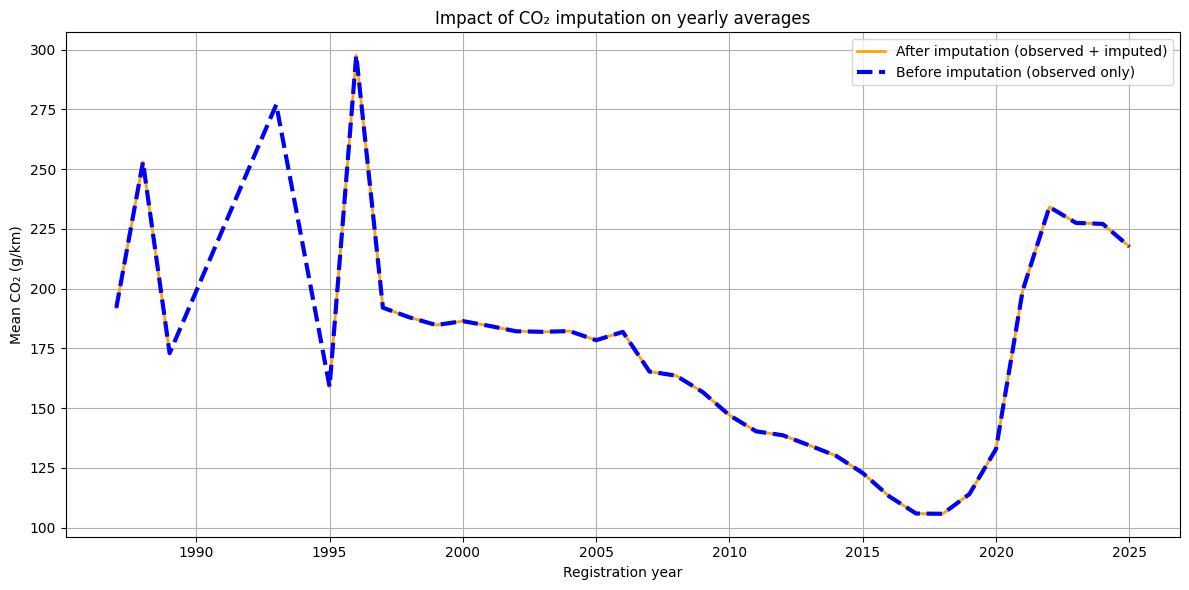

In [20]:
# ============================================================
# SANITY PLOT (EXACTLY V1 DEFINITIONS)
# ============================================================

mean_before = (
    reg["co2_observed_v1"]
    .dropna()
    .groupby(reg.loc[reg["co2_observed_v1"].notna(), "year_v1"])
    .mean()
)

mean_after = reg["co2_final_v1plot"].groupby(reg["year_v1"]).mean()

plt.figure(figsize=(12, 6))
plt.plot(mean_after.index, mean_after.values,
         label="After imputation (observed + imputed)",
         color="orange", linewidth=2)

plt.plot(mean_before.index, mean_before.values,
         label="Before imputation (observed only)",
         color="blue", linewidth=3, linestyle="--", zorder=3)

plt.xlabel("Registration year")
plt.ylabel("Mean CO₂ (g/km)")
plt.title("Impact of CO₂ imputation on yearly averages")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"C:\Users\s15832\Documents\Project\weightproject\Outputs\co2_sanity_plot.png")
plt.show()


In [21]:
# ============================================================
# VALIDATION: ARTIFICIAL MISSINGNESS
# (FIXED: reuse the same decoding + imputation helpers)
# ============================================================
print("\nRunning CO₂ imputation validation...")

observed_mask = reg["co2_clean"].notna()
reg_val = reg.loc[observed_mask].copy()

reg_val["co2_real"] = reg_val["co2_clean"]

np.random.seed(42)
reg_val["is_masked"] = False
mask_idx = reg_val.sample(frac=0.2).index
reg_val.loc[mask_idx, "is_masked"] = True
reg_val.loc[mask_idx, "co2_clean"] = np.nan

print(f"Artificially masked CO₂ values: {len(mask_idx):,}")

merged_val = reg_val.merge(ofv_small, on="regnr", how="left")
merged_val["fuel_decoded"] = decode_primary_fuel(merged_val["TEKN_DRIVSTOFF"])
merged_val["fueleff_final"] = merged_val["forbruk_clean"].fillna(merged_val["fueleff_ofv"])

merged_val = impute_co2(merged_val)
merged_val = merged_val.rename(columns={"co2_final": "co2_imputed"})


Running CO₂ imputation validation...
Artificially masked CO₂ values: 530,888


Generating validation plot...
MAE  : 4.15 g/km
RMSE : 11.12 g/km


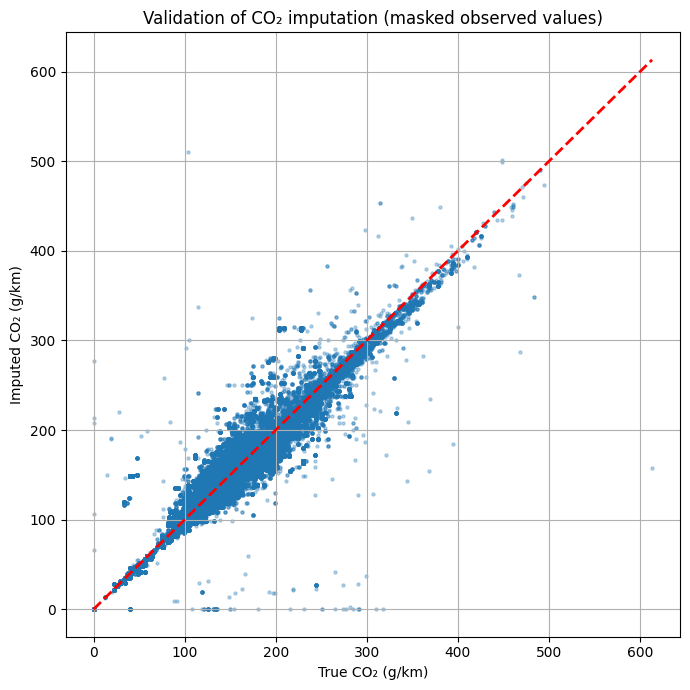

In [22]:
# ============================================================
# VALIDATION METRICS AND SCATTER PLOT
# ============================================================
print("Generating validation plot...")

val = merged_val.loc[merged_val["is_masked"]].dropna(subset=["co2_real", "co2_imputed"])

mae = (val["co2_real"] - val["co2_imputed"]).abs().mean()
rmse = np.sqrt(((val["co2_real"] - val["co2_imputed"]) ** 2).mean())

print(f"MAE  : {mae:.2f} g/km")
print(f"RMSE : {rmse:.2f} g/km")

plt.figure(figsize=(7, 7))
plt.scatter(val["co2_real"], val["co2_imputed"], s=5, alpha=0.3)

lims = [
    min(val["co2_real"].min(), val["co2_imputed"].min()),
    max(val["co2_real"].max(), val["co2_imputed"].max()),
]
plt.plot(lims, lims, "r--", linewidth=2)

plt.xlabel("True CO₂ (g/km)")
plt.ylabel("Imputed CO₂ (g/km)")
plt.title("Validation of CO₂ imputation (masked observed values)")
plt.grid(True)
plt.tight_layout()
plt.savefig(
    r"C:\Users\s15832\Documents\Project\weightproject\Outputs\co2_validation_scatter.png"
)
plt.show()

In [23]:
# ============================================================
# SANITY CHECK — COVERAGE AND INTERSECTION DIAGNOSTICS
# ============================================================
# Total unique vehicles in REGTEK (legal registry universe)
print("Unique regnr in REGTEK:", reg["regnr"].nunique())

# Total unique vehicles in OFV AFTER deduplication
# (technical/specification universe)
print("Unique regnr in OFV (deduped):", ofv_small["regnr"].nunique())

# Vehicles present in BOTH datasets (intersection)
print("Intersection:", common_mask.sum())

Unique regnr in REGTEK: 7121936
Unique regnr in OFV (deduped): 4338789
Intersection: 3641193


In [24]:
# ============================================================
# SAVE FINAL REGTEK DATA
# ============================================================
print("\nPreparing final REGTEK for saving...")

# Missingness after should reflect what we actually save
missing_co2_after = reg["co2_final"].isna().sum()

print("Final REGTEK columns:")
print(reg.columns.tolist())

# Free memory after large merge to avoid unnecessary RAM usage
del merged
import gc; gc.collect()

print("\nSaving REGTEK with imputed CO₂...")
reg.to_parquet(
    r"C:\Users\s15832\Documents\Project\weightproject\Outputs\REGTEK_CO2_imputed.parquet",
    index=False
)
print("Saved.")


Preparing final REGTEK for saving...
Final REGTEK columns:
['TEKN_KJM', 'EIER_NAVN', 'EIER_ETTERNAVN', 'EIER_FORNAVN', 'EIER_MELLOMNAVN', 'EIER_FNR_ONR', 'STATUS_DOD', 'EIER_ADRESSE', 'EIER_POSTNR', 'EIER_POSTSTED', 'EIER_KOMMUNE_NUMMER', 'EIER_FYLKE', 'MEDEIER_NAVN', 'MEDEIER_ETTERNAVN', 'MEDEIER_FORNAVN', 'MEDEIER_MELLOMNAVN', 'MEDEIER_FNR_ONR', 'MEDEIER_ADRESSE', 'MEDEIER_POSTNR', 'MEDEIER_POSTSTED', 'LEASINGTAKER_NAVN', 'LEASINGTAKER_ETTERNAVN', 'LEASINGTAKER_FORNAVN', 'LEASINGTAKER_MELLOMNAVN', 'LEASINGTAKER_FNR_ONR', 'LEASINGTAKER_ADRESSE', 'LEASINGTAKER_POSTNR', 'LEASINGTAKER_POSTSTED', 'KJORINGENS_ART', 'TEKN_KJM_PERSJ', 'TEKN_KJM_FARGE', 'TEKN_UNR', 'TEKN_REG_F_G', 'TEKN_REG_F_G_N', 'TEKN_REG_EIERSKIFTE_DATO', 'TEKN_REG_EIER_DATO', 'TEKN_AVREG_DATO', 'TEKN_VRAKET_DATO', 'TEKN_UTFORT_DATO', 'TEKN_REG_STATUS', 'TEKN_BRUKTIMP', 'TEKN_MERKE', 'TEKN_MERKENAVN', 'TEKN_MODELL', 'TEKN_TKNAVN', 'TEKN_TUK_VERDI', 'TEKN_KJTGRP', 'TEKN_MOTORKODE', 'TEKN_MOTORYTELSE', 'TEKN_SLAGVOLUM', 'T

In [25]:
# ============================================================
# MISSINGNESS RATIOS
# ============================================================
n_rows = len(reg)
ratio_before = missing_co2_before / n_rows
ratio_after  = missing_co2_after  / n_rows

print("\n========== MISSINGNESS RATIOS ==========")
print(f"Missing CO₂ ratio before: {ratio_before:.3%}")
print(f"Missing CO₂ ratio after : {ratio_after:.3%}")
print("========================================\n")


========== MISSINGNESS RATIOS ==========
Missing CO₂ ratio before: 62.729%
Missing CO₂ ratio after : 43.769%

